In [16]:
# Imports
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import numpy as np

In [17]:
# Setting the directory for landmarks
landmarks_dir = "../psl_numbers"

In [18]:
# Finding the maximum number of frames for any gesture
import os

landmark_filenames = list(os.listdir(landmarks_dir))
len(landmark_filenames)

480

In [19]:
gesture_landmarks = []
labels = []

for i, filename in enumerate(landmark_filenames):
  label = int(filename.split("_")[0]) - 1
  labels.append(label)
  landmarks = np.loadtxt(landmarks_dir + '/' + filename, delimiter=",").reshape(-1, 75*3)
  gesture_landmarks.append(landmarks)

In [20]:
gesture_landmarks[0].shape

(76, 225)

In [21]:
max_frames = 119

In [22]:
# Full gesture landmarks has arrays with empty frames to reach the same max amount
full_gesture_landmarks = []

for landmarks in gesture_landmarks:
  remaining_frames = max_frames - landmarks.shape[0]

  if remaining_frames == 0:
    full_gesture_landmarks.append(landmarks)
    continue

  # FOR GHULAM SHABBIR: Create the remaining_array according to the padding as required here, currently this is 0 padding
  remaining_array = np.zeros(shape=(remaining_frames, 75*3))
  full_gesture_landmarks.append(np.concatenate((landmarks, remaining_array)))


In [23]:
all_landmarks = np.array(full_gesture_landmarks)

In [24]:
all_landmarks.shape

(480, 119, 225)

In [25]:
# One Hot Encoding Labels
labels = to_categorical(np.array(labels))

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(all_landmarks, labels, test_size=0.05, random_state=25)

In [27]:
X_test.shape

(24, 119, 225)

In [28]:
X_train.shape

(456, 119, 225)

In [99]:
model = Sequential()
model.add(Input(shape=(119,75*3)))
model.add(LSTM(16, return_sequences=True, activation='tanh', kernel_regularizer=K.regularizers.L2(1e-3)))
model.add(BatchNormalization())
model.add(LSTM(8, return_sequences=False, activation='tanh', kernel_regularizer=K.regularizers.L1(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

checkpoint_filepath = "./model_checkpoints/local_hammad_laptop_checkpoint.model.keras"
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, monitor="val_categorical_accuracy", mode="max", save_best_only=True)
early_stopping_callback = EarlyStopping(monitor="val_categorical_accuracy", patience=600)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=25, min_lr=0.0005)
optimizer = K.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history_callback = model.fit(X_train, y_train, batch_size=4, epochs=2000, validation_split=0.2, validation_batch_size=20, callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr])

Epoch 1/2000
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - categorical_accuracy: 0.1128 - loss: 2.5598 - val_categorical_accuracy: 0.0978 - val_loss: 2.3727 - learning_rate: 0.0010
Epoch 2/2000
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - categorical_accuracy: 0.1110 - loss: 2.3850 - val_categorical_accuracy: 0.0870 - val_loss: 2.3593 - learning_rate: 0.0010
Epoch 3/2000
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - categorical_accuracy: 0.1260 - loss: 2.3664 - val_categorical_accuracy: 0.0978 - val_loss: 2.3510 - learning_rate: 0.0010
Epoch 4/2000
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - categorical_accuracy: 0.1199 - loss: 2.3531 - val_categorical_accuracy: 0.0870 - val_loss: 2.3446 - learning_rate: 0.0010
Epoch 5/2000
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - categorical_accuracy: 0.0989 - loss: 2.3443 - val_categorical_accuracy: 0.0978 - val_loss: 2.3429 - learning_rate: 0.0010
Epoch 6/2000
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - categorical_accuracy: 0.1049 - loss: 2.3430 - val_categorica

In [100]:
import datetime
current_time = datetime.datetime.now()
model.save(f"psl_hammad_local_laptop_2000_epoch_sngle_dense_16_8_lstm_{current_time}.keras")

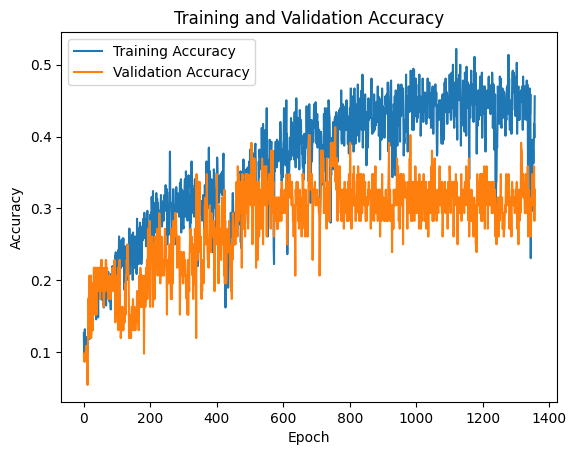

In [101]:
import matplotlib as mp

import matplotlib.pyplot as plt

# Get the accuracy values from the history callback
accuracy = history_callback.history['categorical_accuracy']
val_accuracy = history_callback.history['val_categorical_accuracy']

# Plot the accuracy values
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

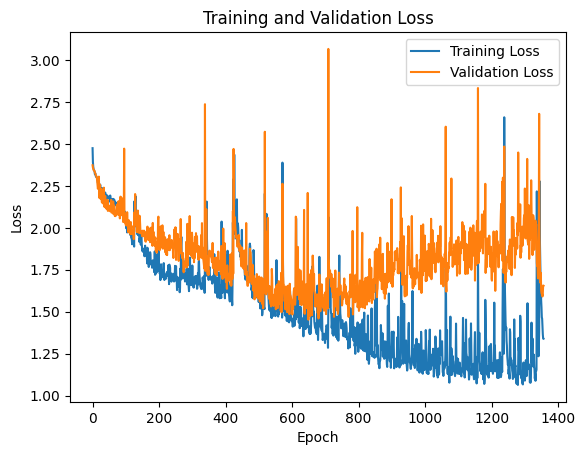

In [102]:
loss = history_callback.history['loss']
val_loss = history_callback.history['val_loss']

# Plot the accuracy values
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [103]:
yhat = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


In [104]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [105]:
ytrue

[6, 6, 3, 5, 3, 6, 2, 8, 2, 5, 3, 1, 6, 0, 2, 8, 8, 8, 8, 9, 5, 5, 7, 7]

In [106]:
yhat

[4, 5, 2, 5, 4, 5, 2, 5, 2, 4, 5, 1, 5, 4, 2, 5, 4, 5, 5, 7, 5, 5, 1, 2]

In [107]:
from sklearn.metrics import accuracy_score

In [108]:
accuracy_score(ytrue, yhat)

0.2916666666666667

In [109]:
checkpoint_model = tf.keras.models.load_model("./model_checkpoints/local_hammad_laptop_checkpoint.model.keras")

In [110]:
yhat = checkpoint_model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


In [111]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [112]:
accuracy_score(ytrue, yhat)

0.3333333333333333